# <font color='red'>SGD Algorithm to predict movie ratings</font>

**There will be some functions that start with the word "grader" ex: grader_matrix(), grader_mean(), grader_dim() etc, you should not change those function definition.<br><br>Every Grader function has to return True.**

<pre>
1. Download the data from <a href='https://drive.google.com/open?id=1-1z7iDB52cB6_JpO7Dqa-eOYSs-mivpq'>here</a>.
2. The data will be of this format, each data point is represented as a triplet of user_id, movie_id and rating.
<table>
<tr><th>user_id</th><th>movie_id</th><th>rating</th></tr>
<tr><td>77</td><td>236</td><td>3</td></tr>
<tr><td>471</td><td>208</td><td>5</td></tr>
<tr><td>641</td><td>401</td><td>4</td></tr>
<tr><td>31</td><td>298</td><td>4</td></tr>
<tr><td>58</td><td>504</td><td>5</td></tr>
<tr><td>235</td><td>727</td><td>5</td></tr>
</table>

## <font color='red'>Task 1</font>

<font color='red'><b>Predict the rating for a given (user_id, movie_id) pair </b> </font>


Predicted rating $\hat{y}_{ij}$ for user i, movied j pair is calcuated as $\hat{y}_{ij} = \mu + b_i + c_j + u_i^T v_j$ , here we will be finding the best values of $b_{i}$ and $c_{j}$ using SGD algorithm with the optimization problem for N users and M movies is defined as

$$
L = \min_{ b, c, \{ u_i \}_{i=1}^N, \{ v_j \}_{j=1}^M}
\quad
\alpha \Big(
    \sum_{j} \sum_{k} v_{jk}^2 
    + \sum_{i} \sum_{k} u_{ik}^2 
    + \sum_{i} b_i^2
    + \sum_{j} c_i^2
    \Big)
+ \sum_{i,j \in \mathcal{I}^{\text{train}}}
    (y_{ij} - \mu - b_i - c_j - u_i^T v_j)^2
$$

<ul>
<li><span class="math">\(\mu\)</span> : scalar mean rating</li>
<li><span class="math">\(b_i\)</span> : scalar bias term for user <span class="math">\(i\)</span></li>
<li><span class="math">\(c_j\)</span> : scalar bias term for movie <span class="math">\(j\)</span></li>
<li><span class="math">\(u_i\)</span> : K-dimensional vector for user <span class="math">\(i\)</span></li>
<li><span class="math">\(v_j\)</span> : K-dimensional vector for movie <span class="math">\(j\)</span></li>
</ul>

* We will be giving you some functions, please write code in that functions only.
* After every function, we will be giving you expected output, please make sure that you get that output. 

1. Construct adjacency matrix with the given data, assuming its graph and the weight of each edge is the rating given by user to the movie.

<img src='https://i.imgur.com/rmUCGMb.jpg' width=200>

You can construct this matrix like $A[i][j]=r_{ij}$ here $i$ is user_id, $j$ is movie_id and $r_{ij}$ is rating given by user $i$ to the movie $j$.

Hint : you can create adjacency matrix using <a href='https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html'> csr_matrix</a>

2. We will Apply SVD decomposition on the Adjaceny matrix <a href='https://stackoverflow.com/a/31528944/4084039'>link1</a>, <a href='https://machinelearningmastery.com/singular-value-decomposition-for-machine-learning/'> link2</a> and get three matrices $U, \sum, V$ such that $U \times \sum \times V^T = A$, <br> 
if $A$ is of dimensions $N \times M$ then <br>
$U$ is of $N \times k$, <br>
$\sum$ is of $k \times k$ and <br>
$V$ is $M \times k$ dimensions. <br>

    * So the matrix $U$ can be represented as matrix representation of users, where each row $u_{i}$ represents a k-dimensional vector for a user

    * So the matrix $V$ can be represented as matrix representation of movies, where each row $v_{j}$ represents a k-dimensional vector for a movie.
3. Compute $\mu$ , $\mu$  represents the mean of all the rating given in the dataset.(write your code in <font color='blue'>def m_u()</font>)
4. For each unique user initilize a bias value $B_{i}$ to zero, so if we have $N$ users $B$ will be a $N$ dimensional vector, the $i^{th}$ value of the $B$ will corresponds to the bias term for $i^{th}$ user (write your code in <font color='blue'>def initialize()</font>)

5. For each unique movie initilize a bias value $C_{j}$ zero, so if we have $M$ movies $C$ will be a $M$ dimensional vector, the $j^{th}$ value of the $C$ will corresponds to the bias term for $j^{th}$ movie (write your code in <font color='blue'>def initialize()</font>)

6. Compute dL/db_i (Write you code in <font color='blue'> def derivative_db()</font>)
7. Compute dL/dc_j(write your code in <font color='blue'> def derivative_dc()</font>

8. Print the mean squared error with predicted ratings.

9. You can choose any learning rate and regularization term in the range $10^{-3}  \text{ to } 10^2$.
10. __Bonus__: Instead of using SVD decomposition you can learn the vectors $u_i$, $v_j$ with the help of SGD algo similar to $b_i$ and $c_j$.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from IPython.display import display

In [3]:
from matplotlib import pyplot as plt
from matplotlib import style
style.use(style='seaborn-deep')

In [4]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, auc, mean_squared_error, plot_confusion_matrix, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.utils.extmath import randomized_svd

In [5]:
from scipy.sparse import csr_matrix

In [6]:
from tqdm import tqdm

In [7]:
import numpy as np
import pandas as pd

<font color='red'> Reading the csv file </font>

In [8]:
data = pd.read_csv(filepath_or_buffer='ratings_train.csv')
display(data.head())
display(data.shape)
display(data.describe())

,user_id,item_id,rating
0,772,36,3
1,471,228,5
2,641,401,4
3,312,98,4
4,58,504,5


(89992, 3)

,user_id,item_id,rating
count,89992.000000,89992.000000,89992.000000
mean,461.579151,423.584663,3.529480
std,266.720677,330.264625,1.125686
min,0.000000,0.000000,1.000000
25%,253.000000,173.000000,3.000000
50%,446.000000,319.000000,4.000000
75%,681.000000,629.000000,4.000000
max,942.000000,1680.000000,5.000000


<font color='red'>Create your adjacency matrix </font>

In [9]:
rows = data['user_id'].values
cols = data['item_id'].values
rates = data['rating'].values

In [10]:
adjacency_matrix = csr_matrix(arg1=(rates, (rows, cols)))

In [11]:
display(adjacency_matrix.shape)

(943, 1681)

<font color='cyan'>Grader function - 1</font>

In [12]:
def grader_matrix(matrix):
    assert(matrix.shape == (943, 1681))
    return True

grader_matrix(matrix=adjacency_matrix)

True

The unique items in the given csv file are 1662 only . But the id's vary from 0-1681 but they are not continuous and hence 
you'll get matrix of size 943x1681.

<font color='red'> SVD decompostion</font>

Sample code for SVD decompostion

In [13]:
matrix = np.random.random(size=(20, 10))
U, Sigma, VT = randomized_svd(M=matrix, n_components=5, n_iter=5, random_state=None)
print(U.shape)
print(Sigma.shape)
print(VT.T.shape)

(20, 5)
(5,)
(10, 5)


<font color='red'>Write your code for SVD decompostion</font>

In [14]:
# Please use adjacency_matrix as matrix for SVD decompostion.
# You can choose n_components as your choice.

U, Sigma, VT = randomized_svd(M=adjacency_matrix, n_components=10, n_iter=10, random_state=None)
print(U.shape)
print(Sigma.shape)
print(VT.T.shape)

(943, 10)
(10,)
(1681, 10)


<font color='red'>Compute mean of ratings</font>

In [15]:
def m_u(ratings):
    """
    In this function, we will compute mean for all the ratings.
    """
    return ratings.mean()

In [16]:
mu = m_u(ratings=data['rating'])
print(mu)

3.529480398257623


<font color='cyan'>Grader function - 2</font>

In [17]:
def grader_mean(mu):
    assert(np.round(mu, 3) == 3.529)
    return True
mu = m_u(ratings=data['rating'])
grader_mean(mu)

True

<font color='red'>Initialize $B_{i}$ and $C_{j}$

Hint : Number of rows of adjacent matrix corresponds to user dimensions($B_{i}$), number of columns of adjacent matrix corresponds to movie dimensions ($C_{j}$)

In [18]:
def initialize(dim):
    """
    In this function, we will initialize bias value 'B' and 'C'.
    """
    return np.zeros(shape=dim)

In [19]:
b = initialize(dim=adjacency_matrix.shape[0])

In [20]:
c = initialize(dim=adjacency_matrix.shape[1])

<font color='cyan'>Grader function - 3</font>

In [21]:
def grader_dim(b, c):
    assert(len(b) == 943 and np.sum(b) == 0)
    assert(len(c) == 1681 and np.sum(c) == 0)
    return True
grader_dim(b=b, c=c)

True

__My solution for derivative of optimization function__

![](https://user-images.githubusercontent.com/63338657/192339507-c6d6b03f-cf64-4386-a50e-338d0541da32.jpg)

<font color='red'>Compute dL/db_i</font>

In [22]:
def derivative_db(i, j, y, b, c, U, V, mu, alpha):
    """
    In this function, we will compute dL/db_i.
    """
    dLdb = (alpha * (2 * b[i])) - (2 * (y - mu - b[i] - c[j] - np.dot(a=U[i], b=V.T[j])))
    return dLdb

<font color='cyan'>Grader function - 4 </font>

In [23]:
def grader_db(value):
    assert(np.round(value, 3) == -0.931)
    return True

U1, Sigma, V1 = randomized_svd(M=adjacency_matrix, n_components=2, n_iter=5, random_state=24)
# Please don't change random state.
# Here we are considering n_componets = 2 for our convinence.

alpha = 0.01 
value = derivative_db(i=312, j=98, y=4, b=b, c=c, U=U1, V=V1, mu=mu, alpha=alpha)
grader_db(value=value)

True

<font color='red'>Compute dL/dc_j</font>

In [24]:
def derivative_dc(i, j, y, b, c, U, V, mu, alpha):
    """
    In this function, we will compute dL/dc_j.
    """
    dLdc = (alpha * (2 * c[j])) - (2 * (y - mu - b[i] - c[j] - np.dot(a=U[i], b=V.T[j])))
    return dLdc

<font color='cyan'>Grader function - 5</font>

In [25]:
def grader_dc(value):
    assert(np.round(value, 3) == -2.929)
    return True

U1, Sigma, V1 = randomized_svd(adjacency_matrix, n_components=2,n_iter=5, random_state=24)
# Please don't change random state.
# Here we are considering n_componets = 2 for our convinence.

alpha = 0.01 
value = derivative_dc(i=58, j=504, y=5, b=b, c=c, U=U1, V=V1, mu=mu, alpha=alpha)
grader_dc(value=value)

True

<font color='red'>Compute MSE (mean squared error) for predicted ratings</font>


For each epoch, print the MSE value.

<pre>
for each epoch:
    for each pair of (user, movie):
        b_i =  b_i - learning_rate * dL/db_i
        c_j =  c_j - learning_rate * dL/dc_j
predict the ratings with formula
</pre>

$\hat{y}_{ij} = \mu + b_i + c_j + \text{dot_product}(u_i, v_j)$

In [26]:
def compute_MSE(adj_mat, user_ids, item_ids, ratings, U, V, mu, learning_rate, alpha, epochs):
    """
    This function computes the MSE.
    """
    dim_b, dim_c = adj_mat.shape
    b = initialize(dim=dim_b)
    c = initialize(dim=dim_c)
    
    mse_list = list()
    epoch_list = list(range(1, epochs+1))
    
    for epoch in epoch_list:
        for (i, j, y) in zip(user_ids, item_ids, ratings):
            dLdb = derivative_db(i=i, j=j, y=y, b=b, c=c, U=U, V=V, mu=mu, alpha=alpha)
            dLdc = derivative_dc(i=i, j=j, y=y, b=b, c=c, U=U, V=V, mu=mu, alpha=alpha)
            b[i] = b[i] - learning_rate * dLdb # Updating the user biases.
            c[j] = c[j] - learning_rate * dLdc # Updating the item biases.
        
        ratings_hat = list()
        for (i, j) in zip(user_ids, item_ids):
            y_hat = mu + b[i] + c[j] + np.dot(a=U[i], b=V.T[j])
            ratings_hat.append(y_hat)
        
        mse = mean_squared_error(y_true=ratings, y_pred=ratings_hat)
        mse_list.append(mse)
        print("Epoch: {} and MSE: {}.".format(epoch, mse))
    
    return epoch_list, mse_list

In [27]:
epoch_list, mse_list = compute_MSE(adj_mat=adjacency_matrix,
                                   user_ids=rows,
                                   item_ids=cols,
                                   ratings=rates,
                                   U=U,
                                   V=VT,
                                   mu=mu,
                                   learning_rate=0.001,
                                   alpha=0.01,
                                   epochs=50)

Epoch: 1 and MSE: 1.0777083774495166.
Epoch: 2 and MSE: 1.0038592524986305.
Epoch: 3 and MSE: 0.964667655650658.
Epoch: 4 and MSE: 0.9402173804898271.
Epoch: 5 and MSE: 0.9233459478657735.
Epoch: 6 and MSE: 0.9108891797191738.
Epoch: 7 and MSE: 0.9012456508199451.
Epoch: 8 and MSE: 0.8935200937095401.
Epoch: 9 and MSE: 0.887171768335053.
Epoch: 10 and MSE: 0.8818531407126377.
Epoch: 11 and MSE: 0.877329231286404.
Epoch: 12 and MSE: 0.8734343866680405.
Epoch: 13 and MSE: 0.8700477190052865.
Epoch: 14 and MSE: 0.8670784375174175.
Epoch: 15 and MSE: 0.8644567002240754.
Epoch: 16 and MSE: 0.8621276880717818.
Epoch: 17 and MSE: 0.8600476362829805.
Epoch: 18 and MSE: 0.858181097125644.
Epoch: 19 and MSE: 0.8564990022236691.
Epoch: 20 and MSE: 0.8549772588607925.
Epoch: 21 and MSE: 0.8535957121061695.
Epoch: 22 and MSE: 0.8523373633678522.
Epoch: 23 and MSE: 0.8511877724592224.
Epoch: 24 and MSE: 0.8501345934832705.
Epoch: 25 and MSE: 0.8491672099665996.
Epoch: 26 and MSE: 0.84827644474255.
E

<font color='red'>Plot epoch number vs MSE </font>
* Epoch number on X-axis
* MSE on Y-axis

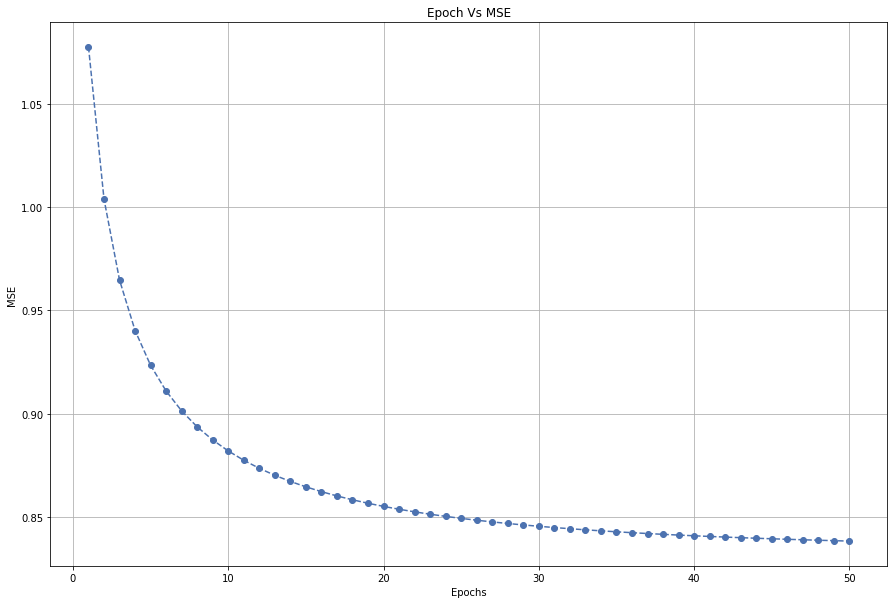

In [28]:
plt.figure(figsize=(15, 10))
plt.plot(epoch_list, mse_list, 'o--')
plt.title(label='Epoch Vs MSE')
plt.xlabel(xlabel='Epochs')
plt.ylabel(ylabel='MSE')
plt.grid()
plt.show()

<br>

## <font color='red'> Task 2</font>

- For this task you have to consider the user_matrix U and the user_info.csv file.
- You have to consider is_male columns as  output features and rest as input features. Now you have to fit a model by posing this problem as binary classification task.
- You can apply any model like Logistic regression or Decision tree and check the performance of the model. 
- Do plot confusion matrix after fitting your model and write your observations how your model is performing in this task.
- Optional work- You can try scaling your U matrix. Scaling means changing the values of n_components while performing svd
  and then check your results.

In [29]:
user_info_df = pd.read_csv(filepath_or_buffer='user_info.csv.txt')
display(user_info_df.shape)
display(user_info_df.head())

(943, 4)

,user_id,age,is_male,orig_user_id
0,0,24,1,1
1,1,53,0,2
2,2,23,1,3
3,3,24,1,4
4,4,33,0,5


In [30]:
display(user_info_df['is_male'].value_counts().to_frame())

,is_male
1,670
0,273


In [31]:
y = user_info_df['is_male'].values

In [32]:
display(U.shape)

(943, 10)

In [33]:
U_df = pd.DataFrame(data=U)
U_df['y'] = y

In [34]:
display(U_df.shape)
display(U_df.head())

(943, 11)

,0,1,2,3,4,5,6,7,8,9,y
0,0.066226,0.007889,-0.012531,-0.086164,0.024870,0.006661,0.080050,-0.027577,0.067478,0.019588,1
1,0.013644,-0.048895,0.056554,0.015809,-0.012036,0.017731,0.010708,-0.010218,0.028463,-0.009315,0
2,0.005438,-0.025128,0.020028,0.032832,0.035080,0.001919,0.007690,-0.001000,-0.021176,-0.003429,1
3,0.005704,-0.018211,0.010898,0.021867,0.013920,-0.014180,0.012246,-0.009110,-0.012789,0.006124,1
4,0.034122,0.009005,-0.044054,-0.016049,0.004326,-0.021502,0.095573,0.079497,-0.017122,0.029123,0


In [35]:
def get_gender_predictions(data_df, label, scaling=False):
    """
    This function predicts the gender.
    """
    X = data_df.drop(labels=[label], axis=1).values
    y = data_df[label].values
    
    if scaling:
        std_scaler = StandardScaler()
        std_scaler.fit(X=X)
        X = std_scaler.transform(X=X)
    
    clf = SGDClassifier(loss='log_loss')
    clf.fit(X=X, y=y)
    
    plot_confusion_matrix(estimator=clf, X=X, y_true=y)
    
    y_pred = clf.predict(X=X)
    
    fpr, tpr, thresholds = roc_curve(y_true=y, y_score=y_pred)
    print("AUC: {}.".format(auc(x=fpr, y=tpr)))
    print("Accuracy: {}".format(accuracy_score(y_true=y, y_pred=y_pred)))

AUC: 0.5876387294297742.
Accuracy: 0.7486744432661718


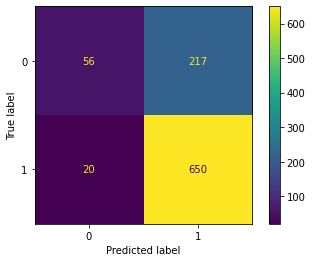

In [36]:
get_gender_predictions(data_df=U_df, label='y')

AUC: 0.6374173090591001.
Accuracy: 0.7083775185577943


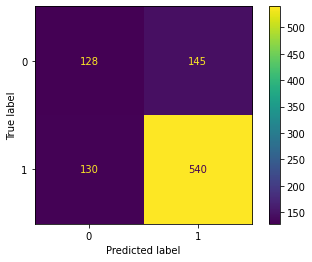

In [37]:
get_gender_predictions(data_df=U_df, label='y', scaling=True)

After scaling is set to `True`, the model performance has improved.

End of the file.